In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import json
import os
import ast

from his_geo import extractor
from his_geo import geocoder

import geopy
from geopy.distance import geodesic
import shapely.geometry
from shapely.geometry import MultiPolygon, Polygon
from itertools import combinations

import matplotlib.pyplot as plt


# Set prompt and other parameters

In [2]:
prompt = """
I would like you to take on the roles of both a Geographer and a Historian. 
You possess extensive knowledge in Chinese geography and history, with a particular expertise in historical toponymy. 
Your task is to extract precise addresses of historical locations from texts.
When I provide a scholarly text analyzing the location of one or several ancient place names, please identify and extract both the ancient place names and their corresponding locations from the text. 
Keep the following in mind:
1. If the text presents differing opinions of the same place name's location from various scholars, only extract the most correct location that the author of the text acknowledges or agrees with. Do not include information that the author disputes.
2. If an ancient name is mentioned in the text but no location is provided, please do not extract the information for this place name.
3. Present the extracted information always in Chinese and strictly adhere to the following format:
   "Place Name 1", "Location 1"
   "Place Name 2", "Location 2"
   Please do not include any explanation, verb or extraneous information.

The text is as follows:

         """

In [ ]:
api_key = ""

In [3]:
models = ["chatgpt"]
chatgpt_model_versions = ["gpt-3.5-turbo-1106", "gpt-4-1106-preview"]

# Create extractor and run

In [4]:
llm_extractor = extractor.Extractor(prompt, output_dir="./evaluation/", 
                                    model="chatgpt", model_version="gpt-3.5-turbo-1106", api_key=api_key)

In [11]:
df = pd.read_csv('./evaluation/input.csv')
texts = df['text'].tolist()

In [6]:
results = llm_extractor.extract_texts(texts)

Extracting text 0 to ./evaluation/extracted_results_chatgpt_gpt-3.5-turbo-1106.json
Extracting text 1 to ./evaluation/extracted_results_chatgpt_gpt-3.5-turbo-1106.json
Extracting text 2 to ./evaluation/extracted_results_chatgpt_gpt-3.5-turbo-1106.json
Extracting text 3 to ./evaluation/extracted_results_chatgpt_gpt-3.5-turbo-1106.json
Extracting text 4 to ./evaluation/extracted_results_chatgpt_gpt-3.5-turbo-1106.json
Extracting text 5 to ./evaluation/extracted_results_chatgpt_gpt-3.5-turbo-1106.json
Extracting text 6 to ./evaluation/extracted_results_chatgpt_gpt-3.5-turbo-1106.json
Extracting text 7 to ./evaluation/extracted_results_chatgpt_gpt-3.5-turbo-1106.json
Extracting text 8 to ./evaluation/extracted_results_chatgpt_gpt-3.5-turbo-1106.json
Extracting text 9 to ./evaluation/extracted_results_chatgpt_gpt-3.5-turbo-1106.json
Extracting text 10 to ./evaluation/extracted_results_chatgpt_gpt-3.5-turbo-1106.json
Extracting text 11 to ./evaluation/extracted_results_chatgpt_gpt-3.5-turbo-

In [7]:
llm_extractor = extractor.Extractor(prompt, output_dir="./evaluation/", 
                                    model="chatgpt", model_version="gpt-4-1106-preview", api_key=api_key)

In [6]:
import json
with open('./evaluation/extracted_results_chatgpt_gpt-4-1106-preview.json', 'r', encoding='utf-8-sig') as f:
    results = json.load(f)

In [8]:
results = llm_extractor.extract_texts(texts)

Extracting text 0 to ./evaluation/extracted_results_chatgpt_gpt-4-1106-preview.json
Extracting text 1 to ./evaluation/extracted_results_chatgpt_gpt-4-1106-preview.json
Extracting text 2 to ./evaluation/extracted_results_chatgpt_gpt-4-1106-preview.json
Extracting text 3 to ./evaluation/extracted_results_chatgpt_gpt-4-1106-preview.json
Extracting text 4 to ./evaluation/extracted_results_chatgpt_gpt-4-1106-preview.json
Extracting text 5 to ./evaluation/extracted_results_chatgpt_gpt-4-1106-preview.json
Extracting text 6 to ./evaluation/extracted_results_chatgpt_gpt-4-1106-preview.json
Extracting text 7 to ./evaluation/extracted_results_chatgpt_gpt-4-1106-preview.json
Extracting text 8 to ./evaluation/extracted_results_chatgpt_gpt-4-1106-preview.json
Extracting text 9 to ./evaluation/extracted_results_chatgpt_gpt-4-1106-preview.json
Extracting text 10 to ./evaluation/extracted_results_chatgpt_gpt-4-1106-preview.json
Extracting text 11 to ./evaluation/extracted_results_chatgpt_gpt-4-1106-pre

# Post-processing

In [37]:
def json_to_dataframe(json_file):
    with open(json_file, 'r', encoding="utf-8-sig") as f:
        data = json.load(f)
    df = pd.DataFrame(columns=['id', 'toponym', 'location'])
    for key, value in data.items():
        result = value.split('\n')
        for item in result:
            if item != '':
                try:
                    row = {'id': key, 'toponym': item.split(',')[0].strip(), 'location': item.split(',')[1].strip()}
                except:
                    row = {'id': key, 'toponym': item, 'location': ''}
                df.loc[len(df)] = row
    return df


def match_ids(df_result, df_original):
    df_ids = df_original[['id']].copy()

    df_result.set_index('id', inplace=True)
    df_result.index.name = None
    df_ids.index = df_ids.index.astype('int64')
    df_result.index = df_result.index.astype('int64')

    df_result = df_result.merge(df_ids, left_index=True, right_index=True, how='left')
    df_result = df_result[['id', 'toponym', 'location']]
    return df_result

In [38]:
df_original = pd.read_csv('./evaluation/input.csv')

json_dir = './evaluation/'
json_files = [i for i in os.listdir(json_dir) if i.endswith('.json')]

for json_file in json_files:
    df_result = json_to_dataframe(json_dir + json_file)
    df_result = match_ids(df_result, df_original)
    df_result.to_csv(json_dir + json_file[:-5] + '.csv', index=False, encoding='utf-8-sig')

# Geocoding

In [3]:
files_dir = './evaluation/'
files = [i for i in os.listdir(files_dir) if "extracted_results" in i and i.endswith('.csv')]
for file in files:
    df = pd.read_csv(files_dir + file, encoding='utf-8-sig')
    addresses = df['location'].tolist()
    geocoder_evaluate = geocoder.Geocoder(addresses, 
                                         lang="ch", 
                                         projection_crs="EPSG:2333", 
                                         address_separator="-")
    geocoder_evaluate.match_address()
    geocoder_evaluate.detect_direction()
    geocoder_evaluate.calculate_point()
    df_geocoded = geocoder_evaluate.data.reset_index().copy()
    df = df.reset_index().copy()
    df = df.merge(df_geocoded, left_index=True, right_index=True, how='left')
    df.to_csv(files_dir + file[:-4] + '_geocoded.csv', index=False, encoding='utf-8-sig')

# Evaluate

$$ 
closeness(p_i, p_j) = \begin{cases} \frac{\cos{(\frac{\pi}{n} \cdot distance(p_i, p_j)) + 1 }}{2} &, \ if \ 0 \le x \le n \\0 &, \ if \ x \gt n \end{cases} 
$$

While p_i and p_j represent the point of the extracted location and the ground truth location, respectively, the distance is the geodesic distance (km) between two points, and n is a predetermined baseline distance (km) that acts as a threshold.

The closeness ranges from 0 to 1. When the distance is zero, the function yields a closeness value of 1. When the distance is between 0 and the baseline distance n, the closeness follows a non-linear cosine decay pattern, characterized by a gradual decrease, followed by a rapid decline, and finally a slow decrease to 0. As the distance exceeds the baseline distance n, the closeness value becomes zero.

We determined the baseline distance n to be the maximum geodesic distance between any two points within the polygon of the highest accuracy level matched with the groundtruth location.


$$
\text{Precision} = \frac{1}{T} \sum_{i=1}^{T} \left( \frac{1}{E_i} \sum_{j=1}^{E_i} C_{ij} \right)
$$


The Precision is calculated as the average of the average closeness scores for locations extracted from each text in the dataset. 
Here, $T$ represents the total number of texts in the dataset. 
For each text, denoted as i, there is a set of locations extracted from it, and $E_i$ is the number of locations extracted from text i.
$C_{ij}$ represents the closeness score of location j in text i. 

$$
\text{Recall} = \frac{1}{T} \sum_{i=1}^{T} \left( \frac{1}{G_i} \sum_{j=1}^{G_i} \left( \frac{1}{E_{ij}} \sum_{k=1}^{E_{ij}} C_{ijk} \right) \right)
$$

The Recall is calculated as the average of the average of the average closeness scores for extracted locations matched with each ground truth location from each text in the dataset. 
Here, $T$ represents the total number of texts in the dataset. 
For each text, denoted as i, there is a set of ground truth locations, and $G_i$ is the number of ground truth locations in text i. 
For each ground truth location, denoted as j, there is one or a set of locations extracted by the model, and $E_{ij}$ represents the number of extracted locations matched with ground truth location ij.
$C_{ijk}$ represents the closeness score of extracted location k matched with ground truth location j in text i.


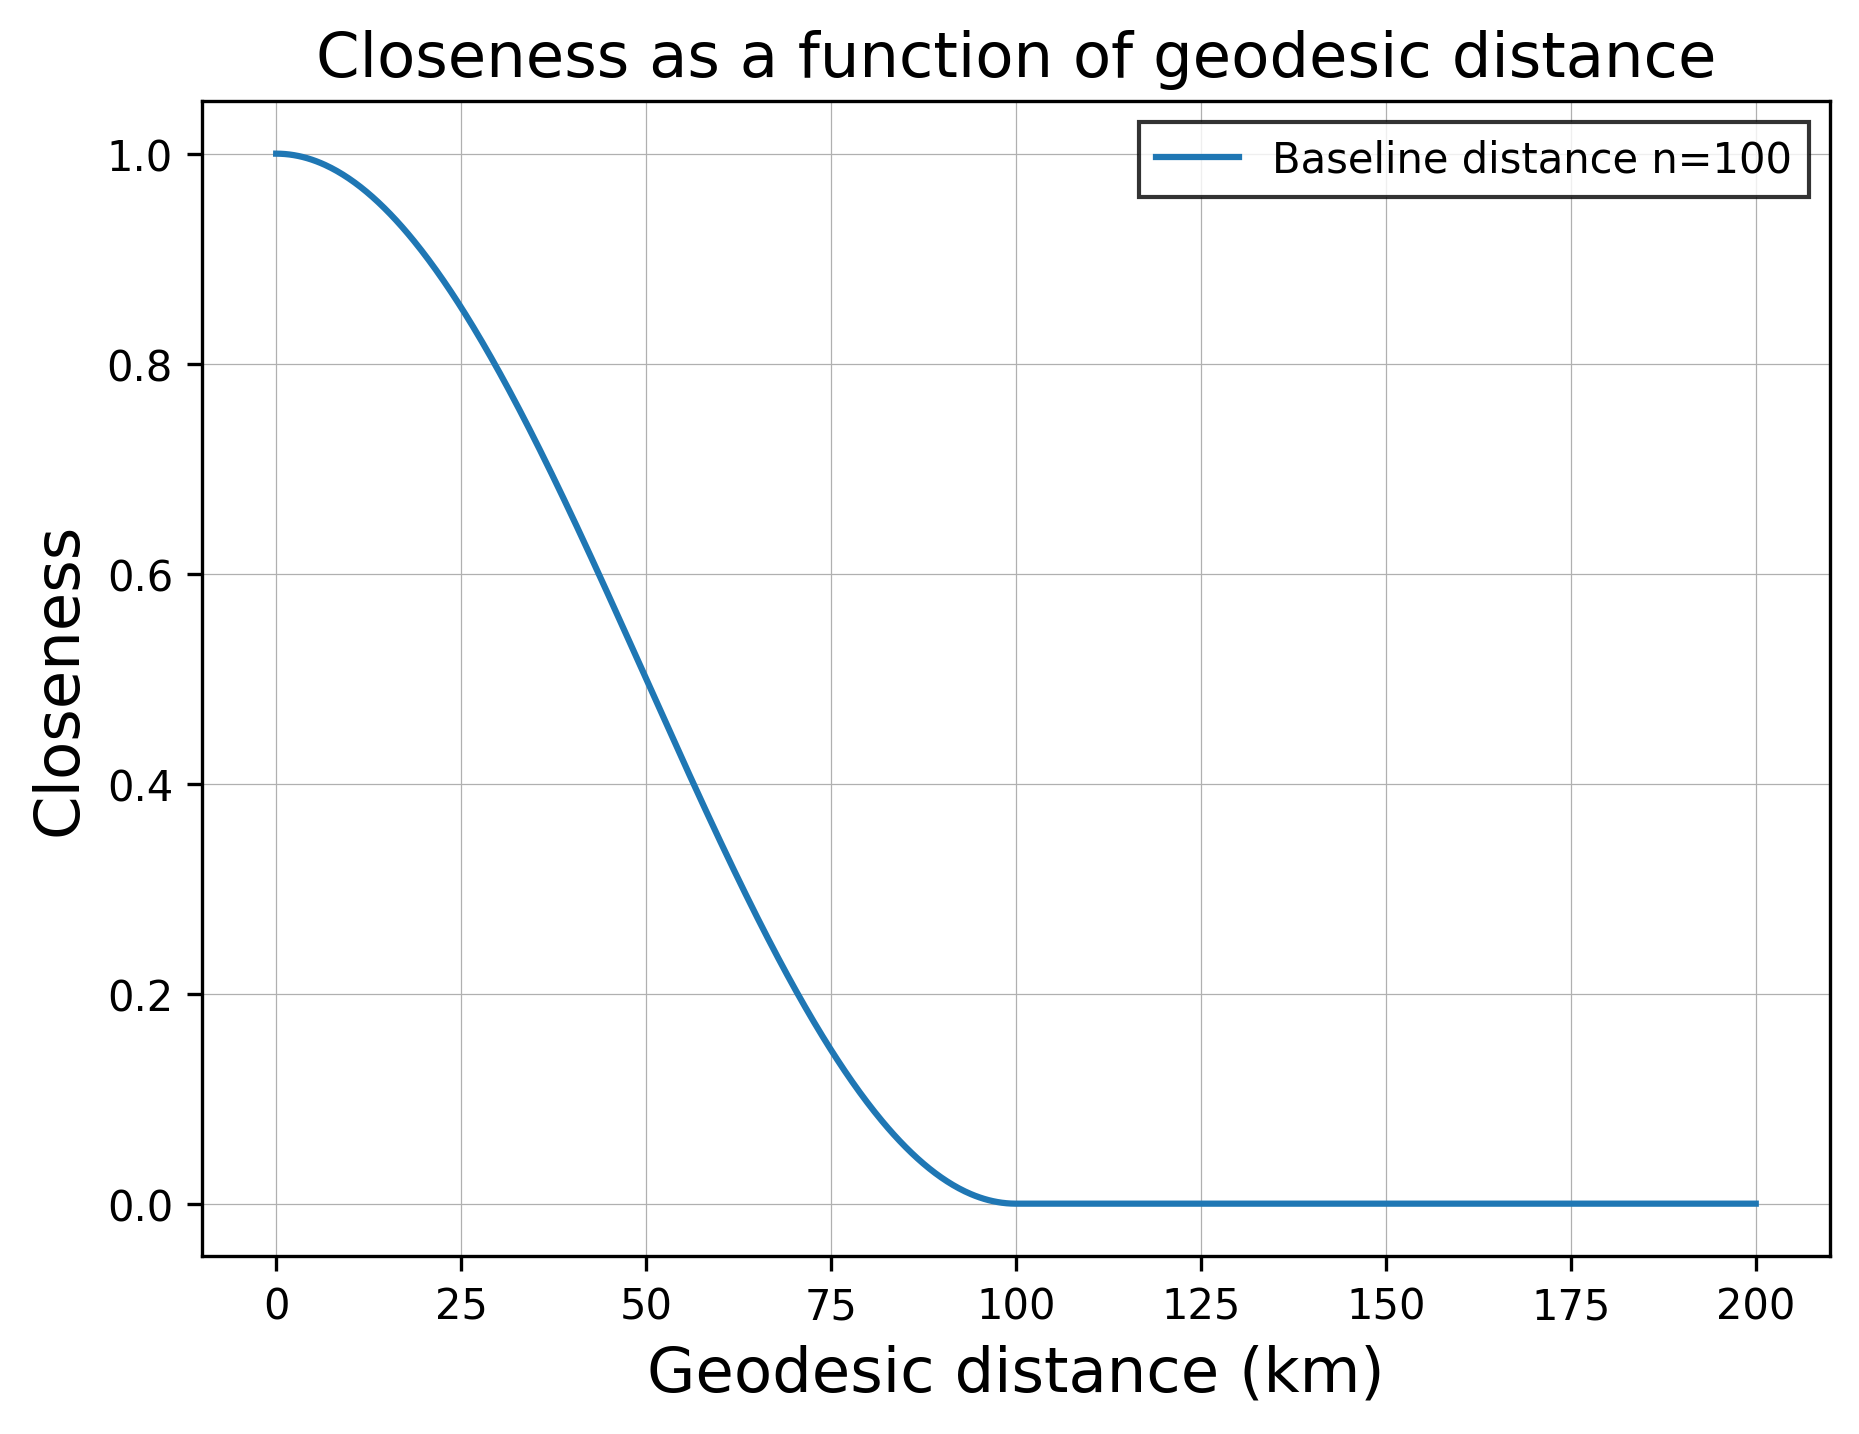

In [5]:
def closeness(x, n):
    """
    Calculate the closeness of the extracted result to the benchmark result
    :param x (km): geodesic distance between the extracted point and the benchmark point
    :param n (km): baseline distance (max geodesic distance inside the most accurate level polygon of the benchmark data)
    """
    if x <= n:
        return (np.cos(x*(np.pi/n))+1)/2
    else:
        return 0

n = 100  # Baseline distance decided by the max length of the most accurate level polygon of the benchmark data
x_values = np.linspace(0, 2*n, 1000)  # x from 0 to 2 times the baseline distance


# Calculate closeness values
closeness_values = [closeness(x, n) for x in x_values]

# Plotting
plt.figure(figsize=(7, 5), dpi=300)
plt.plot(x_values, closeness_values, label=f'Baseline distance n={n}')
plt.xlabel('Geodesic distance (km)', fontsize=15)
plt.ylabel('Closeness', fontsize=15)
plt.title('Closeness as a function of geodesic distance', fontsize=15)
plt.grid(True, linestyle='-', linewidth=0.3)
plt.legend(fancybox=False, edgecolor='black')
plt.show()


In [21]:
def shapely_point_to_geopy(point_shapely):
    return (point_shapely.y, point_shapely.x)


def calculate_max_distance_in_polygon(polygon):
    max_distance = 0

    if isinstance(polygon, Polygon):
        polygons = [polygon]
    elif isinstance(polygon, MultiPolygon):
        polygons = [p for p in polygon.geoms]

    for poly in polygons:
        points = np.array(poly.exterior.coords)
        points = points[:, [1, 0]]  # Swap coordinates for geodesic calculations
        for i, point1 in enumerate(points):
            for point2 in points[i+1:]:
                distance = geodesic(point1, point2).kilometers
                max_distance = max(max_distance, distance)

    return max_distance


def calculate_geo_closeness(point1, point2, base_polygon):
    # Geodesic Distance between two points
    point1, point2 = shapely_point_to_geopy(point1), shapely_point_to_geopy(point2)
    distance =  geodesic(point1, point2).kilometers
    # Max distance inside the most accurate level polygon of the benchmark data
    n = calculate_max_distance_in_polygon(base_polygon)
    # Closeness
    closeness_value = closeness(distance, n)
    return closeness_value


def calculate_geo_closeness_for_all_text(gdf_result, gdf_benchmark, gdf_database):
    # Check if the number of unique ids in the result is the same as the benchmark
    if len(gdf_result['id'].unique()) != len(gdf_benchmark['id'].unique()):
        print("Number of unique ids in the result is not the same as the benchmark")
    else:
        gdf_result['closeness'] = 0
        gdf_result['target_toponym'] = None
        # Iterate through each text (section)
        for id in gdf_benchmark['id'].unique():
            gdf_section_benchmark = gdf_benchmark[gdf_benchmark['id'] == id]
            gdf_section_result = gdf_result[gdf_result['id'] == id]

            # Iterate through each extracted toponym
            for index_result, row_result in gdf_section_result.iterrows():
                result_toponym = row_result['toponym'].replace("县", "").replace("国", "")
                for index_benchmark, row_benchmark in gdf_section_benchmark.iterrows():
                    benchmark_toponym = row_benchmark['name_response'].replace("县", "").replace("国", "")
                    print(id, result_toponym, benchmark_toponym)
                    if benchmark_toponym in result_toponym or result_toponym in benchmark_toponym:
                        gdf_result.loc[index_result, 'target_toponym'] = benchmark_toponym
                        if row_result['geometry'] is None or row_result['geometry'].is_empty:
                            closeness_value = 0
                        else:
                            if row_benchmark['geometry'] is None or row_benchmark['geometry'].is_empty:
                                # Change in the future
                                closeness_value = 0
                            else:
                                # Get the most accurate level polygon of the benchmark data
                                base_polygon_code = list(ast.literal_eval(row_benchmark['Match Result'])[0].values())[0]
                                base_polygon = gdf_database[gdf_database['CODE'] == base_polygon_code].geometry.iloc[0]
                                closeness_value = calculate_geo_closeness(row_result['geometry'], row_benchmark['geometry'], base_polygon)
                    else:
                        closeness_value = 0
                # Add the closeness score to the result dataframe
                gdf_result.loc[index_result, 'closeness'] = closeness_value

        return gdf_result


def calculate_precision(gdf_result):
    section_precisions = gdf_result.groupby('id')['closeness'].mean()
    total_precision = section_precisions.mean()
    return total_precision


def calculate_recall(gdf_result, gdf_benchmark):

    total_recall = 0
    for id in gdf_result['id'].unique():
        gdf_section_benchmark = gdf_benchmark[gdf_benchmark['id'] == id]
        gdf_section_result = gdf_result[gdf_result['id'] == id]
        section_recall = 0
        for i in range(len(gdf_section_benchmark)):
            benchmark_toponym = gdf_section_benchmark.iloc[i]['name_response'].replace("县", "").replace("国", "")
            if benchmark_toponym not in gdf_section_result['target_toponym'].tolist():
                section_recall += 0
            else:
                section_recall += gdf_section_result[gdf_section_result['target_toponym'] == benchmark_toponym]['closeness'].mean()
        section_recall = section_recall / len(gdf_section_benchmark)
        total_recall += section_recall
    
    total_recall = total_recall / len(gdf_result['id'].unique())

    return total_recall

In [22]:
df_benchmark = pd.read_csv('./evaluation/benchmark.csv', encoding='utf-8-sig')
gdf_benchmark = gpd.GeoDataFrame(df_benchmark, geometry=gpd.points_from_xy(df_benchmark.X, df_benchmark.Y))
gdf_database = gpd.read_file('./data/2020China.geojson', driver='GeoJSON')

In [23]:
file_dir = './evaluation/'
files = [i for i in os.listdir(file_dir) if 'geocoded' in i and i.endswith('.csv')]

for file in files:
    df_result = pd.read_csv(file_dir + file, encoding='utf-8-sig')
    gdf_result = gpd.GeoDataFrame(df_result, geometry=gpd.points_from_xy(df_result.X, df_result.Y))
    gdf_result = calculate_geo_closeness_for_all_text(gdf_result, gdf_benchmark, gdf_database)
    gdf_result.to_file(file_dir + file[:-4] + '_evaluated.geojson', driver='GeoJSON', encoding='utf-8-sig')
    precision = calculate_precision(gdf_result)
    recall = calculate_recall(gdf_result, gdf_benchmark)
    print(file)
    print('Precision:', precision)
    print('Recall:', recall)

1.0 权 ﻿权
1.0 当阳 ﻿权
1.0 章山 ﻿权
1.0 那处 ﻿权
3.0 蓼 湖阳
3.0 湖阳 湖阳
4.0 邓 邓
4.0 邓 邓
5.0 申 ﻿申
5.0 宛城 ﻿申
6.0 吕 吕
6.0 申 吕
7.0 息 ﻿息
7.0 申 ﻿息
8.0 商 商
9.0 蒋 ﻿期思
10.0 析 ﻿析
10.0 白羽 ﻿析
10.0 容城 ﻿析
12.0 庐 ﻿庐
12.0 庐戎 ﻿庐
12.0 庐 ﻿庐
11.0 鄀 鄀
11.0 商密 鄀
11.0 郢 鄀
11.0 番 鄀
11.0 鄢 鄀
13.0 庸 ﻿庸
14.0 宛丘 陈
15.0 沈尹 ﻿沈
15.0 沈 ﻿沈
16.0 城父 ﻿城父
17.0 郧 ﻿郧
17.0 郧 ﻿郧
18.0 州来 州来
19.0 叶 ﻿叶
19.0 许 ﻿叶
20.0 陈 东不羹
20.0 陈 西不羹
20.0 蔡 东不羹
20.0 蔡 西不羹
20.0 不羹 东不羹
20.0 不羹 西不羹
21.0 蔡 上蔡
21.0 蔡 新蔡
21.0 上蔡 上蔡
21.0 上蔡 新蔡
21.0 新蔡 上蔡
21.0 新蔡 新蔡
22.0 白 ﻿白
22.0 白亭 ﻿白
22.0 鄢 ﻿白
22.0 巢邑 ﻿白
23.0 巢 ﻿居巢
23.0 居巢 ﻿居巢
23.0 钟离 ﻿居巢
24.0 钟离 ﻿钟离
25.0 阴大夫 ﻿阴
25.0 阴 ﻿阴
26.0 棠 ﻿棠
27.0 武城 ﻿武城
28.0 蓝 ﻿蓝
28.0 蓝田 ﻿蓝
29.0 苦 ﻿苦
29.0 相 ﻿苦
30.0 荀 ﻿荀
30.0 郇 ﻿荀
31.0 耿 ﻿耿
31.0 耿 魏
31.0 魏 ﻿耿
31.0 魏 魏
32.0 州 州
32.0 温 州
32.0 原 州
32.0 陉 州
33.0 原 ﻿原
33.0 温 ﻿原
33.0 樊 ﻿原
33.0 隰郕 ﻿原
33.0 楼茅 ﻿原
33.0 向 ﻿原
33.0 盟 ﻿原
33.0 州 ﻿原
33.0 陉 ﻿原
33.0 怀 ﻿原
34.0 温 ﻿温
35.0 阳樊 ﻿阳樊
36.0 欑茅 ﻿欑茅
36.0 欑茅 絺
36.0 欑茅 陉
36.0 絺 ﻿欑茅
36.0 絺 絺
36.0 絺 陉
36.0 陉 ﻿欑茅
36.0 陉 絺
36.0 陉 陉
37.0 阳樊 鉏
37.0 温 鉏
37.0 原 鉏


In [ ]:
file_dir = './evaluation/'
files = [i for i in os.listdir(file_dir) if 'test' in i and i.endswith('.geojson')]
for file in files:
    gdf = gpd.read_file(file_dir + file, driver='GeoJSON', encoding='utf-8-sig')
    precision = calculate_precision(gdf)
    recall = calculate_recall(gdf, gdf_benchmark)
    print(file)
    print("Precision:", precision)
    print("Recall:", recall)